In [1]:
import os
import urllib
import sys

from IPython import display
from IPython.display import Image as IPyImage
from IPython.display import HTML as IPyHTML
import ipywidgets as widgets

from datetime import date
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import seaborn as sns

from DRiDO.path_decomposition import generate_path_matrix, path_decomposition
from DRiDO.plot import make_network_viz, make_waterfall_plot, make_cluster_summary
from DRiDO.network_summary import summarize_affinity_matrix
from DRiDO.utils import long_to_ragged_wide_df
from DRiDO.study_utils import compute_glasso_network, make_arg_str
from DRiDO.study_utils import ANIMAL_METADATA_COLS

In [2]:
csv_file = "phenotyping_data.csv"  #@param ["AllData_RZ_20220915.csv", "AllData_RZ_20230108.csv", "AllData_RZ_20230108.csv", "AllData_RZ_across_20230110.csv", "AllData_RZ_across_20230408.csv", "AllData_RZ_within_20230731.csv", "20240323_AllData_RZ_within.csv"]
CSV_PATH = os.path.join('data', csv_file)
SURV_ZSCORE_PATH = os.path.join('data', 'SurvTest.csv')

FORCE_RECOMPUTE = True
MAX_GLASSO_LAMBDA = 0.1
USE_LATENT = True
USE_SCALING = True
SPLIT_META_CLUSTER = True
USE_PARTIAL_CORR = True
CLUSTER_KNN_SPARSITY = 10
NUM_CLUSTERS = 20

RENDER_NETWORK = True
USE_PRE_SELECTED_EXEMPLARS = True

arg_str = make_arg_str(
    date=date.today(),
    lmbda=MAX_GLASSO_LAMBDA,
    latent=USE_LATENT,
    scaling=USE_SCALING,
    k=CLUSTER_KNN_SPARSITY,
    partial_corr=USE_PARTIAL_CORR,
    preselect_exemplars=USE_PRE_SELECTED_EXEMPLARS)

output_dir = f'output/{arg_str}'
os.makedirs(output_dir, exist_ok=True)

sns.set(font_scale=1.5, style='white')
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 1000
pd.options.display.precision = 3

In [3]:
with open(CSV_PATH, 'r') as f:
  wide_df = pd.read_csv(f)
  
long_df = wide_df.melt(id_vars=ANIMAL_METADATA_COLS)
long_df.loc[:, 'measurement_group'] = long_df['variable'].apply(lambda x: x.split('_', 2)[1])
long_df.loc[:, 'timepoint'] = long_df['variable'].apply(lambda x: x.split('_', 2)[0])
long_df.loc[:, 'varname'] = long_df['variable'].apply(lambda x: x.split('_', 2)[2])

In [4]:
# Select measurement timepoint for network construction picking the earliest
# post-intervention timepoint for each measurement group
selected_timepoint = {grp: 'Y1' for grp in sorted(long_df['measurement_group'].unique())}
selected_timepoint['Frailty'] = 'Y1B'
selected_timepoint['MetCage'] = 'Y2'
selected_timepoint['BW'] = 'Y1D'
selected_timepoint['Glu.F'] = 'Y2'
selected_timepoint['Glu.NF'] = 'Y2'
selected_timepoint['Grip'] = 'Y1B'
selected_timepoint['FLOW'] = 'Y2'
selected_measurement_timepoint = ['_'.join(kv) for kv in selected_timepoint.items()]
mask = (long_df['measurement_group'] + '_' + long_df['timepoint']).isin(selected_measurement_timepoint)
long_df = long_df[mask]

In [5]:
with open(SURV_ZSCORE_PATH, 'r') as f:
  surv_zscore_df = pd.read_csv(f)

surv_zscore_df = surv_zscore_df.set_index('TraitName')

real_var_mask = ~np.array([x.endswith('BWTest') or x.endswith('AgeInDays') or x.endswith('FTM') for x in long_df['variable']])
significance_mask = surv_zscore_df.loc[long_df.loc[real_var_mask]['variable'], 'q_add'] < 0.01
significant_measurements = np.unique([x.split('_', maxsplit=1)[1] for x in significance_mask[significance_mask].index])

In [6]:
# Check phenotyping windows
long_df.groupby(['measurement_group', 'timepoint']).apply(lambda x: x[x['varname'] == 'AgeInDays']['value'].agg({
    'min_age_months': lambda x: x.min() / (365 / 12),
    'max_age_months': lambda x: x.max() / (365 / 12),
    'perc_obs': lambda x: pd.notnull(x).sum() / 937.0 * 100.0})).sort_values('max_age_months')

,value,min_age_months,max_age_months,perc_obs
measurement_group,timepoint,,,
Rotarod,Y1,9.699,10.192,96.585
Void,Y1,9.699,10.192,95.624
Frailty,Y1B,9.633,10.225,97.012
Wheel,Y1,9.633,10.225,97.012
Grip,Y1B,9.830,10.290,92.529
Echo,Y1,10.060,10.553,95.624
PIXI,Y1,10.093,10.553,95.518
AS,Y1,10.422,10.882,83.778
CBC,Y1,11.014,11.474,95.197


In [7]:
diet_group2index = {'AL': 0, '1D': 1, '20': 1, '2D': 1, '40': 2}
data_df = long_df.pivot(index=ANIMAL_METADATA_COLS, columns=['measurement_group', 'varname'], values='value')
meta_df = data_df.index.to_frame(index=False).set_index('MouseID')
data_df.columns = data_df.columns.get_level_values(0) + '_' + data_df.columns.get_level_values(1)
data_df = data_df.set_index(data_df.index.get_level_values('MouseID'))

data_df.loc[:, 'Meta_DietGroup'] = [diet_group2index[x.split('-')[1]] for x in data_df.index]
surv_days = meta_df["SurvDays"].loc[data_df.index]
data_df.loc[:, 'Meta_Lifespan'] = surv_days
is_dead = meta_df["Died"].loc[data_df.index].values
data_df.loc[~is_dead, 'Meta_Lifespan'] = None

columns_to_drop = [x for x in data_df.columns if x.endswith('BWTest')]
columns_to_drop += [x for x in data_df.columns if x.endswith('AgeInDays')]
data_df = data_df.drop(columns=columns_to_drop)

mask = meta_df['SurvDays'] > (365 / 12 * 17)  # Set 17 months as cutoff since latest phenotyping is at 16.8 months
surviving_mice = meta_df[mask].index
data_df = data_df.loc[surviving_mice]

In [8]:
results = compute_glasso_network(
    data_df, MAX_GLASSO_LAMBDA, USE_LATENT, USE_SCALING, CLUSTER_KNN_SPARSITY,
    USE_PARTIAL_CORR, SPLIT_META_CLUSTER, FORCE_RECOMPUTE,
    num_clusters=NUM_CLUSTERS, prefix='single_timepoint')

theta, partial_correlation, k_sparse_abs_theta, cluster_df = results
abs_theta = theta.abs()
cov = pd.DataFrame(np.linalg.inv(theta), index=theta.index, columns=theta.columns)

target_nodes = ['Meta_DietGroup', 'Meta_Lifespan', 'BW_BW']
cluster_plot, cluster_associations = make_cluster_summary(
    partial_correlation, cluster_df, target_nodes, ignore=['Age', 'Lifespan', 'Diet', 'CAST'])
cluster_plot.savefig(f'{output_dir}/cluster_meta_heatmap.pdf')
plt.close(cluster_plot.figure)


inter_cluster_cov, exemplars = summarize_affinity_matrix(
    cov, cluster_df, exemplars=None)

association_df = abs_theta.loc[target_nodes].T.copy()
association_df['cluster'] = cluster_df.set_index('var').loc[association_df.index].values

[1.         0.77426368 0.59948425 0.46415888 0.35938137 0.27825594
 0.21544347 0.16681005 0.12915497 0.1       ]


/home/zhenghao/anaconda3/envs/jax_cr/lib/python3.9/site-packages/gglasso/problem.py:253: UserWarning: NOTE: Input data S is rescaled to correlations, this has impact on the scale of the regularization parameters!
  warnings.warn("NOTE: Input data S is rescaled to correlations, this has impact on the scale of the regularization parameters!")
/home/zhenghao/anaconda3/envs/jax_cr/lib/python3.9/site-packages/gglasso/problem.py:254: UserWarning: The output/solution is rescaled to covariances. All model selection output, in particular the optimal regularization parameters in self.reg_params are corresponding to the correlations.
  warnings.warn("The output/solution is rescaled to covariances. All model selection output, in particular the optimal regularization parameters in self.reg_params are corresponding to the correlations.")


ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 35 iterations with status: optimal.
ADMM terminated after 35 iterations with status: optimal.
ADMM terminated after 35 iterations with status: optimal.
ADMM terminated after 35 iterations with status: optimal.
ADMM terminated after 35 iterations with status: optimal.
ADMM terminated after 35 iterations with status: optimal.
ADMM terminated after 35 iterations with status: optimal.
ADMM terminate

In [ ]:
human_readable_label_overwrite = {
    'Activity': 'Activity',
    'Adiposity': 'FTM / LTM\n(Adiposity)',
    'Eosinophils': 'Eosinophils % (of myeloid)',
    'Food intake /\nFrailty': 'Food intake/\nFrailty',
    'Lymphocytes': 'Lymphocyte %\n(% of viable immune cells)',
    'Mature NK cells': 'Mature NK cell %\n(Cd11b+ Cd11c- % of NK cells)',
    'CD62L+ NK cells': 'CD62L+ NK cell %\n(CD62L+ % of NK cells)',
    'MetCage_Delta': 'MetCage_DeltaVCO2',
    'NKG2D+ T cells': 'NKG2D+ T cell %\n(Nkg2d+ % of Cd8+ T cells)',
}

legend_labels = cluster_df.copy()
legend_labels['cluster'].replace(human_readable_label_overwrite, inplace=True)

make_network_viz(
    abs_theta,
    highlighted_nodes=significant_measurements,
    cluster_labels=legend_labels.set_index('var'),
    filename=f'{output_dir}/glasso_graph.html')

Wrote to output/date=2024-08-12_lmbda=0.1_latent=True_scaling=True_k=10_partial_corr=True_preselect_exemplars=True/glasso_graph.html


In [ ]:
selected_cluster_exemplars = {
    'EE': 'Y2_MetCage_EE',
    'Food intake / Frailty': 'Y2_MetCage_Food',
    'BWDelta': 'Y1D_BW_PhenoDelta',
    'Wheel Running': 'Y2_MetCage_WheelSpeed',
    'Activity': 'Y2_MetCage_PedMeters',
    'CD4T': 'Y2_FLOW_CD4T.CD62LnegCD44posPercCD4T',
    'Lymphocytes': 'Y2_FLOW_Lymph.PercViable',
    'Eosinophils': 'Y2_FLOW_Eos.PercMyeloid',
    'NKG2D+ T cells': 'Y2_FLOW_NKG2DposT.CD8posPercNKG2DposT',
    'Mature NK cells': 'Y2_FLOW_NK.CD11BposCD11CnegPercNK',
    'CD62L+ NK cells': 'Y2_FLOW_NK.CD62LposPercNK',
    'RDW': 'Y1_CBC_RDWcv',
    'Hemoglobin': 'Y1_CBC_Hgb',
    'NLR': 'Y1_CBC_NLR',
    'FTM': 'Y1_PIXI_FTM',
    'LTM': 'Y1_PIXI_LTM',
    'Voiding': 'Y1_Void_logTotalVol',
    'Frailty': 'Y2A_Frailty_FrailtyAdj',
    'Glucose': 'Y2_Glu.F_Glucose',
    'Diet': 'Meta_Meta_DietGroup',
    'Lifespan': 'Meta_Meta_Lifespan'
}

In [ ]:
selected_clusters = np.array(list(selected_cluster_exemplars.keys()))
selected_clusters[~np.in1d(selected_clusters, cluster_df['cluster'].values)]
exemplars_df = long_df[long_df['variable'].isin(selected_cluster_exemplars.values())]

In [ ]:
diet_group2index = {'AL': 0, '1D': 1, '20': 1, '2D': 1, '40': 2}
exemplars_df = exemplars_df.pivot(index=ANIMAL_METADATA_COLS, columns=['measurement_group', 'varname'], values='value')
meta_df = exemplars_df.index.to_frame(index=False).set_index('MouseID')
exemplars_df.columns = exemplars_df.columns.get_level_values(0) + '_' + exemplars_df.columns.get_level_values(1)
exemplars_df = exemplars_df.set_index(exemplars_df.index.get_level_values('MouseID'))

exemplars_df.loc[:, 'Meta_DietGroup'] = [diet_group2index[x.split('-')[1]] for x in exemplars_df.index]
surv_days = meta_df["SurvDays"].loc[exemplars_df.index]
exemplars_df.loc[:, 'Meta_Lifespan'] = surv_days
is_dead = meta_df["Died"].loc[exemplars_df.index].values
exemplars_df.loc[~is_dead, 'Meta_Lifespan'] = None

mask = meta_df['SurvDays'] > (365 / 12 * 17)
surviving_mice = meta_df[mask].index
exemplars_df = exemplars_df.loc[surviving_mice]

In [ ]:
results = compute_glasso_network(
    exemplars_df, MAX_GLASSO_LAMBDA, USE_LATENT, USE_SCALING, CLUSTER_KNN_SPARSITY,
    USE_PARTIAL_CORR, SPLIT_META_CLUSTER, FORCE_RECOMPUTE,
    num_clusters=NUM_CLUSTERS, prefix='single_timepoint_exemplars')

theta, partial_correlation, k_sparse_abs_theta, _ = results
abs_theta = theta.abs()
cov = pd.DataFrame(np.linalg.inv(theta), index=theta.index, columns=theta.columns)

[1.         0.77426368 0.59948425 0.46415888 0.35938137 0.27825594
 0.21544347 0.16681005 0.12915497 0.1       ]
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated a

/home/zhenghao/anaconda3/envs/jax_cr/lib/python3.9/site-packages/gglasso/problem.py:253: UserWarning: NOTE: Input data S is rescaled to correlations, this has impact on the scale of the regularization parameters!
  warnings.warn("NOTE: Input data S is rescaled to correlations, this has impact on the scale of the regularization parameters!")
/home/zhenghao/anaconda3/envs/jax_cr/lib/python3.9/site-packages/gglasso/problem.py:254: UserWarning: The output/solution is rescaled to covariances. All model selection output, in particular the optimal regularization parameters in self.reg_params are corresponding to the correlations.
  warnings.warn("The output/solution is rescaled to covariances. All model selection output, in particular the optimal regularization parameters in self.reg_params are corresponding to the correlations.")


ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 20 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminate

/home/zhenghao/anaconda3/envs/jax_cr/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1592: RuntimeWarning: k >= N for N * N square matrix. Attempting to use scipy.linalg.eigh instead.
  warnings.warn("k >= N for N * N square matrix. "


In [ ]:
# Manually lay things out for readability
layout = [
    {'index': 'Diet', 'x': 1500.0, 'y': 935.22},
    {'index': 'Lifespan', 'x': 1500.0, 'y': 18.0},
    {'index': 'Activity', 'x': 1000, 'y': 548.61},
    {'index': 'FTM', 'x': 1070, 'y': 500.48},
    {'index': 'BW', 'x': 625, 'y': 467.74},
    {'index': 'EE', 'x': 1450, 'y': 423.74},
    {'index': 'Acoustic startle', 'x': 675, 'y': 573.48},
    {'index': 'Voiding', 'x': 1000, 'y': 629.48},
    {'index': 'BWDelta', 'x': 500, 'y': 375.74},
    {'index': 'Food intake / Frailty', 'x': 1000, 'y': 659.48},
    {'index': 'Glucose', 'x': 825, 'y': 629.48},
    {'index': 'Wheel Running', 'x': 1300, 'y': 625.35},
    {'index': 'Hemoglobin', 'x': 900, 'y': 545.74},
    {'index': 'RDW', 'x': 1125, 'y': 251.74},
    {'index': 'LTM', 'x': 650, 'y': 350.74},
    {'index': 'Lymphocytes', 'x': 1800, 'y': 250.0},
    {'index': 'Mature NK cells', 'x': 2050, 'y': 550.0},
    {'index': 'Eosinophils', 'x': 2300, 'y': 270.87},
    {'index': 'NLR', 'x': 1950, 'y': 351.74},
    {'index': 'CD4T', 'x': 1700, 'y': 350.87},
    {'index': 'CD62L+ NK cells', 'x': 2200, 'y': 395.74},
    {'index': 'NKG2D+ T cells', 'x': 1850, 'y': 90.0},]

layout = [x for x in layout if x['index'] in selected_cluster_exemplars.keys()]
layout_df = pd.DataFrame(layout).set_index('index')

Computing scores for  191  paths


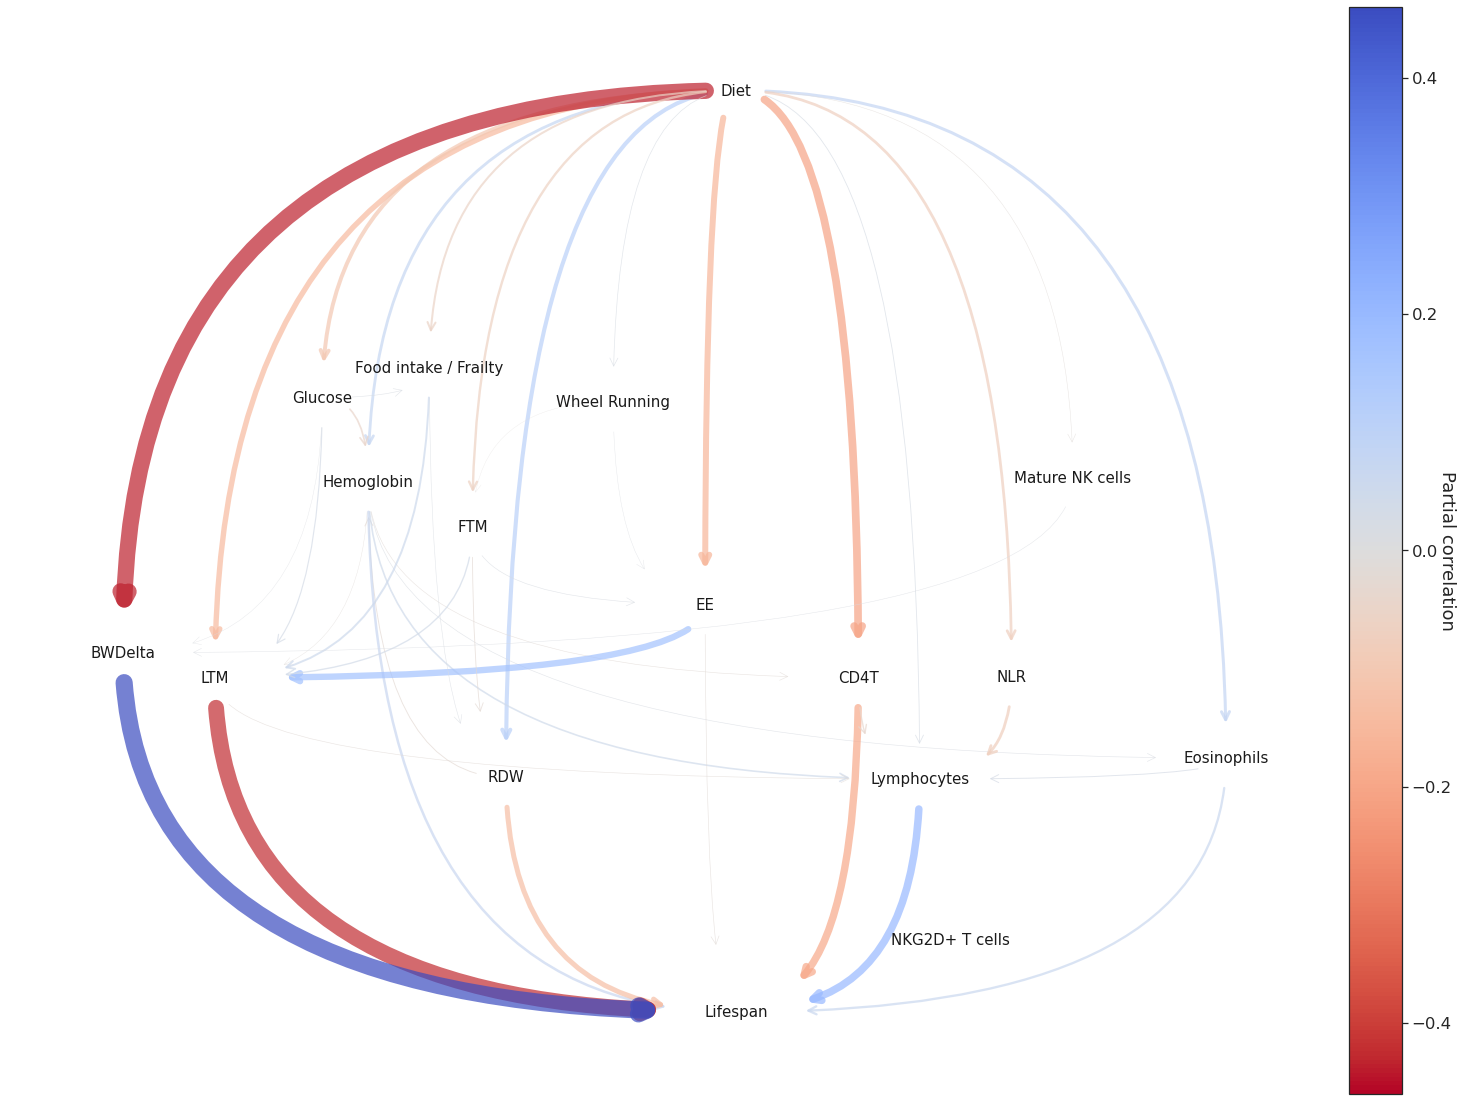

In [ ]:
src = 'Diet'
dst = 'Lifespan'

inter_cluster_pcorr = partial_correlation
feature2name = {v.split('_', maxsplit=1)[-1]: k for k, v in selected_cluster_exemplars.items()}
inter_cluster_pcorr = inter_cluster_pcorr.rename(columns=feature2name)
inter_cluster_pcorr = inter_cluster_pcorr.rename(index=feature2name)
threshold = 0.0

path_subscores = path_decomposition(inter_cluster_pcorr, src, dst, edge_threshold=threshold, max_path_len=4)
all_paths = path_subscores.sort_values('normalized_score', ascending=False)[['readable_path', 'score', 'normalized_score']]

path_score_graph, edge_weights = generate_path_matrix(path_subscores, node_labels=inter_cluster_pcorr.index)
path_score_graph.remove_edge(src, dst)

# Remove unconnected nodes (TODO): Make this automatic instead of manual
path_score_graph.remove_node('Voiding')

path_score_df = nx.to_pandas_adjacency(path_score_graph)
signs = np.sign(inter_cluster_pcorr.loc[path_score_df.index, path_score_df.columns])

edge_threshold_percentile = 40
edge_threshold = np.percentile(path_score_df.values[path_score_df.values > 0], q=edge_threshold_percentile)
waterfall_plot_fig, layout_df = make_waterfall_plot(
    path_score_graph, src, dst, edge_width=1.5e2, jitter=0.15,
    edge_threshold=edge_threshold, layout_df=layout_df, signs=signs, normalize_weights=cov['Meta_DietGroup']['Meta_Lifespan'])
waterfall_plot_fig.savefig(f'{output_dir}/waterfall_plot_signed.pdf', bbox_inches='tight')

In [ ]:
waterfall_plot_fig.tight_layout()


/tmp/ipykernel_488428/1226721270.py:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  waterfall_plot_fig.tight_layout()


In [ ]:
def plot_path_table(df):
  BLUE = '#afcce9'
  RED = '#E99196'

  fig = plt.figure(figsize=((14, 6)))

  font_dict = {
      'fontsize': 15,
      'fontweight': 'bold',
      'verticalalignment': 'center'
  }

  # Plot score bars
  ax_score = plt.subplot(143)
  data = df['score'].values
  colors = [BLUE if v > 0 else RED for v in data]
  ax_score.barh(y=np.arange(len(data), 0, -1), width=data, color=colors)
  text_x_pos = np.min(data) + 2e-3
  for y, val in enumerate(data):
    plt.text(text_x_pos, len(data) - y, ('%0.3f' % val), va='center', fontsize=15)
  sns.despine(bottom=True, left=True)
  ax_score.get_xaxis().set_visible(False)
  ax_score.get_yaxis().set_visible(False)
  ax_score.set_title('Score', loc='left', pad=2., fontdict=font_dict)

  # Plot normalized score bars
  ax_norm_score = plt.subplot(144)
  data = df['normalized_score'].values
  y_pos = np.arange(len(data))
  colors = [BLUE if v > 0 else RED for v in data]
  ax_norm_score.barh(y=np.arange(len(data), 0, -1), width=data, color=colors)
  text_x_pos = np.min(data) - 1e-3
  for y, val in enumerate(data):
    plt.text(text_x_pos, len(data) - y, ('%0.3f' % val), va='center', fontsize=15)
  sns.despine(bottom=True, left=True)
  ax_norm_score.get_xaxis().set_visible(False)
  ax_norm_score.get_yaxis().set_visible(False)
  ax_norm_score.set_title('Normalized Score', loc='left', pad=2., fontdict=font_dict)

  # Plot labels
  ax_label = plt.subplot(141)
  for y, label in enumerate(df['readable_path'].values):
    ax_label.text(0, (len(data) - y) / (len(data) + 1), label, va='center', fontsize=15)
  sns.despine(bottom=True, left=True)
  ax_label.get_xaxis().set_visible(False)
  ax_label.get_yaxis().set_visible(False)
  ax_label.set_title('Path', loc='left', pad=2., fontdict=font_dict)

  return fig

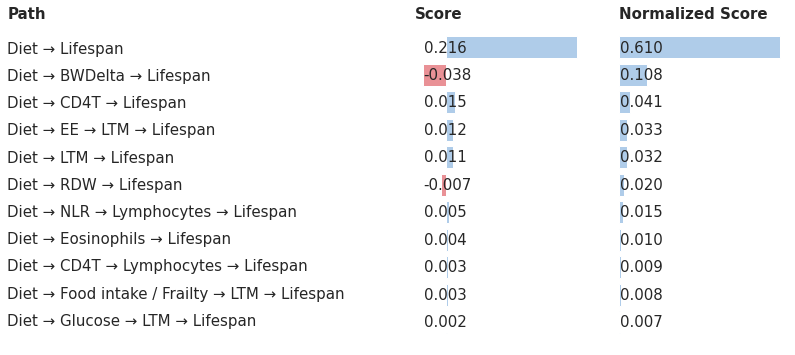

In [ ]:
top_paths = all_paths.sort_values('normalized_score', ascending=False).iloc[:50].reset_index(drop=True)
def highlight_rows(row):
    value = row.loc['score']
    if value > 0:
      color = '#A7CFA7' # Green
    else:
      color = '#E99196' # Red
    return ['background-color: {}'.format(color) for r in row]

path_table_fig = plot_path_table(top_paths[['readable_path', 'score', 'normalized_score']].iloc[0:11])
path_table_fig.savefig(f'{output_dir}/top_path_scores.pdf')

In [ ]:
summary_results = {}

summary_results['Clusters'] = long_to_ragged_wide_df(cluster_df, 'cluster', ['var'], fillna='').reset_index(drop=True).rename_axis("", axis="columns")
summary_results['Waterfall plot'] = waterfall_plot_fig
summary_results['Cluster-meta associations'] = cluster_associations
summary_results['Feature-meta associations'] = association_df
summary_results['Top paths'] = top_paths[['readable_path', 'score', 'normalized_score']].iloc[1:11].style.bar(color=('#E99196', '#A7CFA7')).format(precision=3).hide()
summary_results['Cluster exemplars (data-driven)'] = exemplars.reset_index(name='Feature')

In [ ]:
sub_tabs = [widgets.Output() for i in range(len(summary_results))]
tab = widgets.Tab(sub_tabs)
for i, (k, v) in enumerate(summary_results.items()):
  tab.set_title(i, k)
  with sub_tabs[i]:
    display.display(v)

# Also, write results to excel spreadsheet
with pd.ExcelWriter(f'{output_dir}/tables.xlsx') as writer:
  for k, table_df in summary_results.items():
    if isinstance(table_df, pd.DataFrame):
      table_df.to_excel(writer, sheet_name=k)

display.display(tab)